# Automation of human karyotype analysis using image segmentation and classification methods. Classification

In [1]:
!gdown 1fUWGsTT9GMmQXt9NGqIcmLgaRyWMbWzg

Downloading...
From (original): https://drive.google.com/uc?id=1fUWGsTT9GMmQXt9NGqIcmLgaRyWMbWzg
From (redirected): https://drive.google.com/uc?id=1fUWGsTT9GMmQXt9NGqIcmLgaRyWMbWzg&confirm=t&uuid=abd4c8ff-aa3d-4af8-ad9b-b01260bced55
To: /content/Data.zip
100% 567M/567M [00:09<00:00, 59.7MB/s]


In [2]:
!unzip /content/Data.zip

Streaming output truncated to the last 5000 lines.
  inflating: Data/24_chromosomes_object/JEPG/1101262.jpg  
  inflating: __MACOSX/Data/24_chromosomes_object/JEPG/._1101262.jpg  
  inflating: Data/24_chromosomes_object/JEPG/1071791.jpg  
  inflating: __MACOSX/Data/24_chromosomes_object/JEPG/._1071791.jpg  
  inflating: Data/24_chromosomes_object/JEPG/1051441.jpg  
  inflating: __MACOSX/Data/24_chromosomes_object/JEPG/._1051441.jpg  
  inflating: Data/24_chromosomes_object/JEPG/1053242.jpg  
  inflating: __MACOSX/Data/24_chromosomes_object/JEPG/._1053242.jpg  
  inflating: Data/24_chromosomes_object/JEPG/1055633.jpg  
  inflating: __MACOSX/Data/24_chromosomes_object/JEPG/._1055633.jpg  
  inflating: Data/24_chromosomes_object/JEPG/1050993.jpg  
  inflating: __MACOSX/Data/24_chromosomes_object/JEPG/._1050993.jpg  
  inflating: Data/24_chromosomes_object/JEPG/1057024.jpg  
  inflating: __MACOSX/Data/24_chromosomes_object/JEPG/._1057024.jpg  
  inflating: Data/24_chromosomes_object/JEPG/1

In [3]:
import os
import glob
import random
import xml.etree.ElementTree as ET
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
xml_folder = '/content/Data/24_chromosomes_object/annotations'
image_folder = '/content/Data/24_chromosomes_object/JEPG'
output_folder = '/content/Data/24_chromosomes_cropped'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for xml_file in os.listdir(xml_folder):
    if not xml_file.endswith('.xml'):
        continue

    xml_path = os.path.join(xml_folder, xml_file)
    tree = ET.parse(xml_path)
    root = tree.getroot()

    filename = root.find('filename').text
    image_path = os.path.join(image_folder, filename)
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        continue

    img = Image.open(image_path).convert('RGB')

    for obj in root.findall('object'):
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        cropped = img.crop((xmin, ymin, xmax, ymax))

        label_folder = os.path.join(output_folder, label)
        if not os.path.exists(label_folder):
            os.makedirs(label_folder)

        base_name = os.path.splitext(filename)[0]
        cropped_filename = f"{base_name}_{xmin}_{ymin}_{xmax}_{ymax}.jpg"
        cropped.save(os.path.join(label_folder, cropped_filename))

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])])

dataset = ImageFolder(root=output_folder, transform=transform)

print("Number of classes:", len(dataset.classes))
print("Classes:", dataset.classes)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

Number of classes: 24
Classes: ['A1', 'A2', 'A3', 'B4', 'B5', 'C10', 'C11', 'C12', 'C6', 'C7', 'C8', 'C9', 'D13', 'D14', 'D15', 'E16', 'E17', 'E18', 'F19', 'F20', 'G21', 'G22', 'X', 'Y']
Train samples: 183881, Validation samples: 45971


In [6]:
num_classes = len(dataset.classes)
num_epochs = 5

def create_resnet18(num_classes, device):
    model = models.resnet18(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model.to(device)

def create_mobilenet_v2(num_classes, device):
    model = models.mobilenet_v2(pretrained=True)
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)
    return model.to(device)

def train_model(model, train_loader, val_loader, num_epochs, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / total
        epoch_acc = 100.0 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= val_total
        val_acc = 100.0 * val_correct / val_total
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%\n")

    return model

In [7]:
print("Training ResNet18:")
model_resnet = create_resnet18(num_classes, device)
train_model(model_resnet, train_loader, val_loader, num_epochs, device)
torch.save(model_resnet.state_dict(), "ResNet18.pth")

Training ResNet18:


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 111MB/s]


Epoch [1/5], Loss: 0.3804, Accuracy: 88.70%
Validation Loss: 0.1385, Validation Accuracy: 95.88%

Epoch [2/5], Loss: 0.1275, Accuracy: 96.30%
Validation Loss: 0.1019, Validation Accuracy: 97.11%

Epoch [3/5], Loss: 0.0856, Accuracy: 97.54%
Validation Loss: 0.0971, Validation Accuracy: 97.32%

Epoch [4/5], Loss: 0.0602, Accuracy: 98.23%
Validation Loss: 0.0950, Validation Accuracy: 97.49%

Epoch [5/5], Loss: 0.0469, Accuracy: 98.59%
Validation Loss: 0.0962, Validation Accuracy: 97.61%



In [8]:
print("Training MobileNetV2:")
model_mobilenet = create_mobilenet_v2(num_classes, device)
train_model(model_mobilenet, train_loader, val_loader, num_epochs, device)
torch.save(model_mobilenet.state_dict(), "MobileNetV2.pth")

Training MobileNetV2:


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 97.0MB/s]


Epoch [1/5], Loss: 0.4103, Accuracy: 87.54%
Validation Loss: 0.1122, Validation Accuracy: 96.75%

Epoch [2/5], Loss: 0.1260, Accuracy: 96.36%
Validation Loss: 0.0876, Validation Accuracy: 97.52%

Epoch [3/5], Loss: 0.0938, Accuracy: 97.29%
Validation Loss: 0.0802, Validation Accuracy: 97.83%

Epoch [4/5], Loss: 0.0757, Accuracy: 97.82%
Validation Loss: 0.0865, Validation Accuracy: 97.67%

Epoch [5/5], Loss: 0.0649, Accuracy: 98.11%
Validation Loss: 0.0779, Validation Accuracy: 97.94%



Predicted label: E16
Predicted label: E16


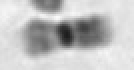

In [9]:
def classify_chromosome(model, image_path, transform, device, class_names):
    model.eval()
    img = Image.open(image_path).convert('RGB')
    img_t = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_t)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted.item()]
    return predicted_class

test_image_path = '/content/Screenshot 2025-03-30 at 19.15.45.png'

predicted_label = classify_chromosome(model_resnet, test_image_path, transform, device, dataset.classes)
print("Predicted label:", predicted_label)
predicted_label = classify_chromosome(model_mobilenet, test_image_path, transform, device, dataset.classes)
print("Predicted label:", predicted_label)

img = Image.open("/content/Screenshot 2025-03-30 at 19.15.45.png").convert('RGB')
img

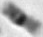

In [10]:
img = Image.open("/content/Data/24_chromosomes_object/JEPG/103064.jpg").convert('RGB')
cropped = img.crop((112, 379, 155, 416))
cropped

In [11]:
img = Image.open("/content/Data/24_chromosomes_object/JEPG/103064.jpg").convert('RGB')
cropped = img.crop((93, 152, 149, 175))
cropped